In [1]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
import pymorphy2
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from utils.data_transformation import remove_stop_words
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [2]:
# 0) Firstly, run tf_idf_for_subdialogs.ipynb to get subdialog_keywords.csv file
df = pd.read_csv(os.path.join("data", "processed_dialog_files", "subdialog_keywords.csv"))

In [3]:
# # Import Dataset
# path_to_articles = '../static/ukr_articles'
# data = pd.read_csv(path_to_articles, sep = ';', header = None)
#
# LANGUAGE = "ua"
# stop_words = remove_stop_words(data, LANGUAGE, "get_stop_words")
#
# # write your number of rows to analyse. max == 695,
# # but to clean and analyse 30 rows is spending 6 minutes
# df = pd.DataFrame(data[:20])
#
# df.columns = ["id", "title", "en_title", "content", "date", "source_url",
#                   "article_url"]
# # df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
# # print(df.target_names.unique())
# df.head()


In [6]:
# Convert to list
data = df.doc.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])


[' Тому лишилися без улову)) А ми з собою підводного ліхтаря не взяли А вчора '
 'місяця не було Кальмари реагують на місячне світло Не було кльову😰 Ну і як '
 'улов ? Бо я вчора ввечері пішов кальмари ловити Зараз гляну Привіт) Привіт) '
 'ну що щось вдалося ? там у words.txt приклади слів які я шукав я закинув на '
 'твою гілку Супер, дякую)) це з практикоюб приходить та коли валгріндом '
 'багато тестиш просто хотів ще нагадати для майбутнього звільняти память '
 'після себе) І не маю на телефоні Я не люблю зум а чому по силці в зумі не '
 'можна без відео ? Давай ? давай в месенджері ? але ти ж в другій країні) '
 'зателефонувати ? ок Ой я так не дуже можу зараз посилання скину набираю) '
 'Набереш мене чи напишеш? зараз з клангом вожуся та mvsc ) я тут баг у твоєму '
 'завданні знайшов а у тебе зараз є трохи часу ? Типу кімната з кухнею '
 'Апартамент Поки ще не маю більше) це ви домик знімаєте ? блін, дуже круто а '
 'ще фотки скинути можеш) ого Та, вчора пізно ввечері доїхали) П

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['тому', 'лишилися', 'без', 'улову', 'ми', 'собою', 'підводного', 'ліхтаря', 'не', 'взяли', 'вчора', 'місяця', 'не', 'було', 'кальмари', 'реагують', 'на', 'місячне', 'світло', 'не', 'було', 'кльову', 'ну', 'як', 'улов', 'бо', 'вчора', 'ввечері', 'пішов', 'кальмари', 'ловити', 'зараз', 'гляну', 'привіт', 'привіт', 'ну', 'що', 'щось', 'вдалося', 'там', 'words', 'txt', 'приклади', 'слів', 'які', 'шукав', 'закинув', 'на', 'твою', 'гілку', 'супер', 'дякую', 'це', 'практикоюб', 'приходить', 'та', 'коли', 'валгріндом', 'багато', 'тестиш', 'просто', 'хотів', 'ще', 'нагадати', 'для', 'маибутнього', 'звільняти', 'память', 'після', 'себе', 'не', 'маю', 'на', 'телефоні', 'не', 'люблю', 'зум', 'чому', 'по', 'силці', 'зумі', 'не', 'можна', 'без', 'відео', 'даваи', 'даваи', 'месенджері', 'але', 'ти', 'другіи', 'краіні', 'зателефонувати', 'ок', 'ои', 'так', 'не', 'дуже', 'можу', 'зараз', 'посилання', 'скину', 'набираю', 'набереш', 'мене', 'чи', 'напишеш', 'зараз', 'клангом', 'вожуся', 'та', 'mvsc', '

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['тому', 'лишилися', 'без', 'улову', 'ми', 'собою', 'підводного', 'ліхтаря', 'не', 'взяли', 'вчора', 'місяця', 'не', 'було', 'кальмари', 'реагують', 'на', 'місячне', 'світло', 'не', 'було', 'кльову', 'ну', 'як', 'улов', 'бо', 'вчора', 'ввечері', 'пішов', 'кальмари', 'ловити', 'зараз', 'гляну', 'привіт', 'привіт', 'ну', 'що', 'щось', 'вдалося', 'там', 'words', 'txt', 'приклади', 'слів', 'які', 'шукав', 'закинув', 'на', 'твою', 'гілку', 'супер', 'дякую', 'це', 'практикоюб', 'приходить', 'та', 'коли', 'валгріндом', 'багато', 'тестиш', 'просто', 'хотів', 'ще', 'нагадати', 'для', 'маибутнього', 'звільняти', 'память', 'після', 'себе', 'не', 'маю', 'на', 'телефоні', 'не', 'люблю', 'зум', 'чому', 'по', 'силці', 'зумі', 'не', 'можна', 'без', 'відео', 'даваи', 'даваи', 'месенджері', 'але', 'ти', 'другіи', 'краіні', 'зателефонувати', 'ок', 'ои', 'так', 'не', 'дуже', 'можу', 'зараз', 'посилання', 'скину', 'набираю', 'набереш', 'мене', 'чи', 'напишеш', 'зараз', 'клангом', 'вожуся', 'та', 'mvsc', 'т

In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
#     """https://spacy.io/api/annotation"""
#     texts_out = []
#     for sent in texts:
#         doc = nlp(" ".join(sent))
#         texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
#     return texts_out

def lemmatization(data, lang, cube):
    """

    :param lang: "ru", "ua" or "en"
    :param cube: only for "ua"an object after these commands cube = Cube(verbose=True); cube.load("uk")
    :return: cleaned text from synonyms
    """
    lemmas = []
    for i in range(len(data)):
        data[i] = " ".join(data[i])

    data = ". ".join(data)

    if lang == "ru":
        lemmas = " ".join(pymorphy2.MorphAnalyzer().parse(np.unicode(word))[0].normal_form for word in msg.split())

    elif lang in ("ua", "en"):
        sentences = cube(data)

        for sentence in sentences:  # note we selected the first sentence (sentence[0])
            sentence_lemma = []
            for entry in sentence:
                sentence_lemma.append(entry.lemma)

            lemmas.append(sentence_lemma)

    return lemmas

In [24]:
from cube.api import Cube

# Remove Stop Words
# data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)
print(data_words_bigrams)

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# # python3 -m spacy download en
# # nlp = spacy.load('en', disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm')
# # cube = Cube(verbose=True)
# # cube.load("en")
#

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams)
# data_lemmatized = lemmatization(data_words_bigrams[:20], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


# cube = ""
# if LANGUAGE == "ua":
#     cube = Cube(verbose=True)
#     cube.load("uk")
#
# elif LANGUAGE == "en":
#     cube = Cube(verbose=True)
#     cube.load("en")

# data_lemmatized = lemmatization(data_words_bigrams, LANGUAGE, cube)
data_lemmatized = data_words_bigrams


[['тому', 'лишилися', 'без', 'улову', 'ми', 'собою', 'підводного', 'ліхтаря', 'не', 'взяли', 'вчора', 'місяця', 'не', 'було', 'кальмари', 'реагують', 'на', 'місячне', 'світло', 'не', 'було', 'кльову', 'ну', 'як', 'улов', 'бо', 'вчора', 'ввечері', 'пішов', 'кальмари', 'ловити', 'зараз', 'гляну', 'привіт', 'привіт', 'ну', 'що', 'щось', 'вдалося', 'там', 'words', 'txt', 'приклади', 'слів', 'які', 'шукав', 'закинув', 'на', 'твою', 'гілку', 'супер', 'дякую', 'це', 'практикоюб', 'приходить', 'та', 'коли', 'валгріндом', 'багато', 'тестиш', 'просто', 'хотів', 'ще', 'нагадати', 'для', 'маибутнього', 'звільняти', 'память', 'після', 'себе', 'не', 'маю', 'на', 'телефоні', 'не', 'люблю', 'зум', 'чому', 'по', 'силці', 'зумі', 'не', 'можна', 'без', 'відео', 'даваи', 'даваи', 'месенджері', 'але', 'ти', 'другіи', 'краіні', 'зателефонувати', 'ок', 'ои', 'так', 'не', 'дуже', 'можу', 'зараз', 'посилання', 'скину', 'набираю', 'набереш', 'мене', 'чи', 'напишеш', 'зараз', 'клангом', 'вожуся', 'та', 'mvsc', '

In [25]:
print(data_lemmatized[:1])
 # Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[['тому', 'лишилися', 'без', 'улову', 'ми', 'собою', 'підводного', 'ліхтаря', 'не', 'взяли', 'вчора', 'місяця', 'не', 'було', 'кальмари', 'реагують', 'на', 'місячне', 'світло', 'не', 'було', 'кльову', 'ну', 'як', 'улов', 'бо', 'вчора', 'ввечері', 'пішов', 'кальмари', 'ловити', 'зараз', 'гляну', 'привіт', 'привіт', 'ну', 'що', 'щось', 'вдалося', 'там', 'words', 'txt', 'приклади', 'слів', 'які', 'шукав', 'закинув', 'на', 'твою', 'гілку', 'супер', 'дякую', 'це', 'практикоюб', 'приходить', 'та', 'коли', 'валгріндом', 'багато', 'тестиш', 'просто', 'хотів', 'ще', 'нагадати', 'для', 'маибутнього', 'звільняти', 'память', 'після', 'себе', 'не', 'маю', 'на', 'телефоні', 'не', 'люблю', 'зум', 'чому', 'по', 'силці', 'зумі', 'не', 'можна', 'без', 'відео', 'даваи', 'даваи', 'месенджері', 'але', 'ти', 'другіи', 'краіні', 'зателефонувати', 'ок', 'ои', 'так', 'не', 'дуже', 'можу', 'зараз', 'посилання', 'скину', 'набираю', 'набереш', 'мене', 'чи', 'напишеш', 'зараз', 'клангом', 'вожуся', 'та', 'mvsc', '

In [26]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('all', 1),
  ('denysgerasymuk', 1),
  ('dmytro', 1),
  ('done', 1),
  ('github_com', 1),
  ('https', 1),
  ('mvsc', 2),
  ('poc_lab', 1),
  ('tree', 1),
  ('txt', 1),
  ('words', 1),
  ('але', 4),
  ('апартамент', 1),
  ('баг', 2),
  ('багато', 1),
  ('без', 3),
  ('блін', 1),
  ('бо', 2),
  ('буду', 1),
  ('було', 4),
  ('більше', 1),
  ('валгрінд', 1),
  ('валгріндом', 2),
  ('валгрінді', 1),
  ('ввечері', 3),
  ('вдалося', 1),
  ('вдається', 1),
  ('вже', 2),
  ('взяли', 1),
  ('ви', 1),
  ('видає', 1),
  ('вожуся', 1),
  ('все', 3),
  ('вчора', 3),
  ('відео', 1),
  ('відправили', 1),
  ('гляну', 1),
  ('гілку', 1),
  ('даваи', 2),
  ('для', 1),
  ('добре', 1),
  ('домик', 1),
  ('доіхали', 1),
  ('другіи', 1),
  ('дуже', 3),
  ('дякую', 2),
  ('діма', 1),
  ('завданні', 1),
  ('заити', 1),
  ('закидуєш', 1),
  ('закину', 1),
  ('закинув', 1),
  ('зараз', 5),
  ('зателефонувати', 1),
  ('затестити', 1),
  ('звільняти', 1),
  ('знаишов', 2),
  ('знімаєте', 1),
  ('зум', 1),
  ('з

In [27]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [28]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"зробить" + 0.024*"можеш" + 0.022*"змозить" + 0.017*"код" + '
  '0.010*"робить" + 0.010*"зараз" + 0.009*"завтра" + 0.008*"треба" + '
  '0.008*"добро" + 0.007*"виид"'),
 (1,
  '0.045*"video" + 0.024*"course" + 0.015*"url" + 0.015*"start" + '
  '0.013*"https" + 0.013*"self" + 0.011*"image" + 0.010*"сервіс" + '
  '0.010*"сервер" + 0.009*"zoom_us"'),
 (2,
  '0.009*"str" + 0.008*"result" + 0.007*"from_len" + 0.007*"if" + '
  '0.007*"запускати" + 0.006*"return" + 0.006*"str_size_m" + 0.006*"иого" + '
  '0.006*"cpp" + 0.005*"capacity_m"'),
 (3,
  '0.006*"створити_нов" + 0.006*"print" + 0.005*"роботі" + 0.004*"range" + '
  '0.004*"ліб" + 0.004*"parse" + 0.004*"скіть" + 0.003*"думка" + '
  '0.003*"нашома" + 0.003*"проекті"'),
 (4,
  '0.016*"com" + 0.016*"дуже" + 0.014*"мат_аналіз" + 0.013*"саит" + '
  '0.012*"написать" + 0.012*"робить" + 0.012*"якщыи" + 0.011*"дяковать" + '
  '0.011*"можеш" + 0.010*"відео"'),
 (5,
  '0.036*"не" + 0.031*"на" + 0.025*"ти" + 0.019*"то" + 0.017*"прост

In [29]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -14.858387320936593

Coherence Score:  0.5201236673668808


## Visualize the topics-keywords

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

d:\python\envs\venv_telegram_analysis\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.183036  0.001276       1        1  32.364319
0     -0.129469 -0.034076       2        1  15.611938
18     0.024035  0.020005       3        1  10.108439
5      0.030665  0.037408       4        1   8.458730
17    -0.206369 -0.223318       5        1   5.476896
12     0.037833 -0.002661       6        1   4.821681
1      0.078936  0.021066       7        1   3.789272
13     0.070436  0.012768       8        1   3.547722
10    -0.357464  0.263168       9        1   3.498376
6     -0.139845 -0.215943      10        1   3.128830
11     0.082669  0.016364      11        1   2.914222
2      0.081813  0.015739      12        1   1.978856
3      0.082244  0.008947      13        1   1.648373
16     0.080060  0.011950      14        1   1.108518
8      0.076157  0.017574      15        1   0.786801
7      0.082446  0.025193      16        1   0.308023
19     0.073107  0.006697      17        1   0.159156
15     0.072769  0.005961      18        1   0.153605
9      0.071571  0.005922      19        1   0.074211
14     0.071440  0.005960      20        1   0.062037, topic_info=     Category        Freq             Term       Total  loglift  logprob
291   Default  121.000000              має  121.000000  30.0000  30.0000
991   Default  144.000000             мочь  144.000000  29.0000  29.0000
2030  Default  114.000000              app  114.000000  28.0000  28.0000
942   Default  176.000000          зробить  176.000000  27.0000  27.0000
1507  Default  125.000000         добавить  125.000000  26.0000  26.0000
...       ...         ...              ...         ...      ...      ...
168   Topic20    0.002054               це   24.032310  -1.9820  -9.0364
527   Topic20    0.002054            немає   45.270958  -2.6153  -9.0364
1238  Topic20    0.002054            якщыи  143.332123  -3.7678  -9.0364
3863  Topic20    0.002054  number_students    3.336404  -0.0075  -9.0364
862   Topic20    0.002054            добро   98.111633  -3.3888  -9.0364

[1000 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
4129      7  0.825164  adelaidex_humbio
4130      2  0.350068               api
4130      7  0.420082               api
4130     11  0.140027               api
2030      3  0.990399               app
...     ...       ...               ...
3291     13  0.519438            інколя
2001      1  0.982286               інф
2609      5  0.947955              інша
2609      8  0.031599              інша
2003      2  0.368765            іспить

[916 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 19, 6, 18, 13, 2, 14, 11, 7, 12, 3, 4, 17, 9, 8, 20, 16, 10, 15])

In [31]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ.update({'MALLET_HOME':r'D:/libs/mallet-2.0.8/'})
mallet_path = 'D:/libs/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(16,
  [('делать', 0.03254593175853018),
   ('мочь', 0.01942257217847769),
   ('дать', 0.01942257217847769),
   ('привет', 0.01837270341207349),
   ('бот', 0.01627296587926509),
   ('сервер', 0.014698162729658792),
   ('видео', 0.014698162729658792),
   ('попробовать', 0.013648293963254593),
   ('человек', 0.012598425196850394),
   ('код', 0.012073490813648294)]),
 (8,
  [('str', 0.08542319749216301),
   ('функціі', 0.028996865203761754),
   ('робить', 0.023510971786833857),
   ('стрічка', 0.0219435736677116),
   ('int', 0.019592476489028215),
   ('size', 0.016457680250783698),
   ('розмір', 0.014890282131661442),
   ('функціть', 0.014106583072100314),
   ('якщыи', 0.014106583072100314),
   ('cstr', 0.014106583072100314)]),
 (5,
  [('app_web', 0.028801071667782986),
   ('app', 0.02813127930341594),
   ('web', 0.024112525117213665),
   ('shore_app', 0.021433355659745478),
   ('jul_whispering', 0.016744809109176157),
   ('file', 0.016075016744809108),
   ('поменять', 0.01607501674480910

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

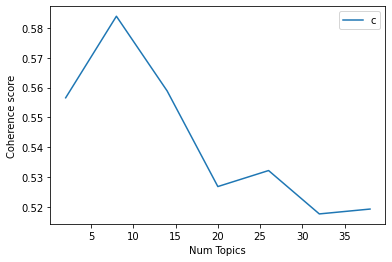

In [34]:
import matplotlib.pyplot as plt
#Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5566
Num Topics = 8  has Coherence Value of 0.5839
Num Topics = 14  has Coherence Value of 0.5589
Num Topics = 20  has Coherence Value of 0.5269
Num Topics = 26  has Coherence Value of 0.5322
Num Topics = 32  has Coherence Value of 0.5177
Num Topics = 38  has Coherence Value of 0.5194


In [36]:

# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.034*"якщыи" + 0.028*"тест" + 0.025*"робить" + 0.020*"чома" + '
  '0.019*"скинуть" + 0.019*"вииидти" + 0.019*"дяковать" + 0.018*"тип" + '
  '0.017*"якии" + 0.017*"речі"'),
 (1,
  '0.036*"можеш" + 0.019*"силок" + 0.018*"ласка" + 0.015*"привіт_паша" + '
  '0.012*"edx" + 0.012*"закинуть" + 0.012*"json" + 0.012*"alison" + '
  '0.012*"закинутить" + 0.012*"list"'),
 (2,
  '0.029*"result" + 0.024*"проблема" + 0.022*"dict" + 0.020*"привіт" + '
  '0.018*"return" + 0.017*"напишеш" + 0.017*"print" + 0.017*"end" + '
  '0.013*"from_len" + 0.013*"def"'),
 (3,
  '0.023*"делать" + 0.019*"мочь" + 0.018*"дать" + 0.017*"бот" + 0.016*"код" + '
  '0.016*"привет" + 0.015*"задание" + 0.015*"добавить" + 0.014*"попробовать" + '
  '0.013*"один"'),
 (4,
  '0.043*"не" + 0.030*"ти" + 0.027*"як" + 0.026*"на" + 0.022*"що" + 0.019*"то" '
  '+ 0.014*"просто" + 0.014*"та" + 0.012*"це" + 0.011*"коли"'),
 (5,
  '0.046*"дуже" + 0.041*"зараз" + 0.034*"мож" + 0.029*"думать" + 0.024*"знать" '
  '+ 0.022*"речі" + 0.0

In [37]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

In [38]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                            axis=0)

# Reset Index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5063,"якщыи, тест, робить, чома, скинуть, вииидти, д...",ага час дуже тест класный тест уснуть май зда...
1,1.0,0.5326,"можеш, силок, ласка, привіт_паша, edx, закинут...",def quantify storage name def qty getter inst...
2,2.0,0.4217,"result, проблема, dict, привіт, return, напише...",arles arse arsle asher ashet aster ates aves ...
3,3.0,0.6243,"делать, мочь, дать, бот, код, привет, задание,...",бот задеплоёный протестировать ладный поработ...
4,4.0,0.8460,"не, ти, як, на, що, то, просто, та, це, коли",Тримай) і де результат чекати та і написати к...


In [41]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv(os.path.join("data", "processed_dialog_files", "subdialogs_topics.csv"))
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,4.0,"не, ти, як, на, що, то, просто, та, це, коли",16.0,0.0792
1.0,4.0,"не, ти, як, на, що, то, просто, та, це, коли",19.0,0.0941
2.0,4.0,"не, ти, як, на, що, то, просто, та, це, коли",8.0,0.0396
3.0,4.0,"не, ти, як, на, що, то, просто, та, це, коли",18.0,0.0891
4.0,4.0,"не, ти, як, на, що, то, просто, та, це, коли",11.0,0.0545
...,...,...,...,...
197.0,2.0,"result, проблема, dict, привіт, return, напише...",NaN,NaN
198.0,17.0,"зробить, зараз, сторінка, працює, спробовать, ...",NaN,NaN
199.0,17.0,"зробить, зараз, сторінка, працює, спробовать, ...",NaN,NaN
200.0,16.0,"можеш, добро, скинутить, завданнии, зробить, в...",NaN,NaN
